In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch

from pathlib import Path
import random
import time
from tqdm import tqdm

import ssl
import urllib.request

ssl._create_default_https_context = ssl._create_unverified_context

data_path = Path('visual-taxonomy-small/')
test_image_path = data_path / 'test_images'
train_image_path = data_path / 'train_images'
print(data_path)

device = "cuda" if torch.cuda.is_available() else "cpu"

BATCH_SIZE = 32

visual-taxonomy-small


In [132]:
df_train = pd.read_csv(data_path / 'train.csv')
df_test = pd.read_csv(data_path / 'test.csv')
print(df_train.describe())
print(df_test.describe())

             id    len  attr_6  attr_7  attr_8  attr_9  attr_10
count  800.0000  800.0     0.0     0.0     0.0     0.0      0.0
mean   399.5000    5.0     NaN     NaN     NaN     NaN      NaN
std    231.0844    0.0     NaN     NaN     NaN     NaN      NaN
min      0.0000    5.0     NaN     NaN     NaN     NaN      NaN
25%    199.7500    5.0     NaN     NaN     NaN     NaN      NaN
50%    399.5000    5.0     NaN     NaN     NaN     NaN      NaN
75%    599.2500    5.0     NaN     NaN     NaN     NaN      NaN
max    799.0000    5.0     NaN     NaN     NaN     NaN      NaN
               id
count  200.000000
mean    99.500000
std     57.879185
min      0.000000
25%     49.750000
50%     99.500000
75%    149.250000
max    199.000000


In [133]:
print(df_train.head())
print('---')
print(df_test.head())

   id     Category  len      attr_1 attr_2   attr_3   attr_4         attr_5  \
0   0  Men Tshirts    5     default  round  printed  default  short sleeves   
1   1  Men Tshirts    5  multicolor   polo    solid    solid  short sleeves   
2   2  Men Tshirts    5     default   polo    solid    solid  short sleeves   
3   3  Men Tshirts    5  multicolor   polo    solid    solid  short sleeves   
4   4  Men Tshirts    5  multicolor   polo    solid    solid  short sleeves   

   attr_6  attr_7  attr_8  attr_9  attr_10  
0     NaN     NaN     NaN     NaN      NaN  
1     NaN     NaN     NaN     NaN      NaN  
2     NaN     NaN     NaN     NaN      NaN  
3     NaN     NaN     NaN     NaN      NaN  
4     NaN     NaN     NaN     NaN      NaN  
---
   id     Category
0   0  Men Tshirts
1   1  Men Tshirts
2   2  Men Tshirts
3   3  Men Tshirts
4   4  Men Tshirts


In [134]:
from PIL import Image

In [135]:
'000000.jpg' in os.listdir(train_image_path)

True

In [136]:
train_range = range(len(df_train))
test_range = range(len(df_test))

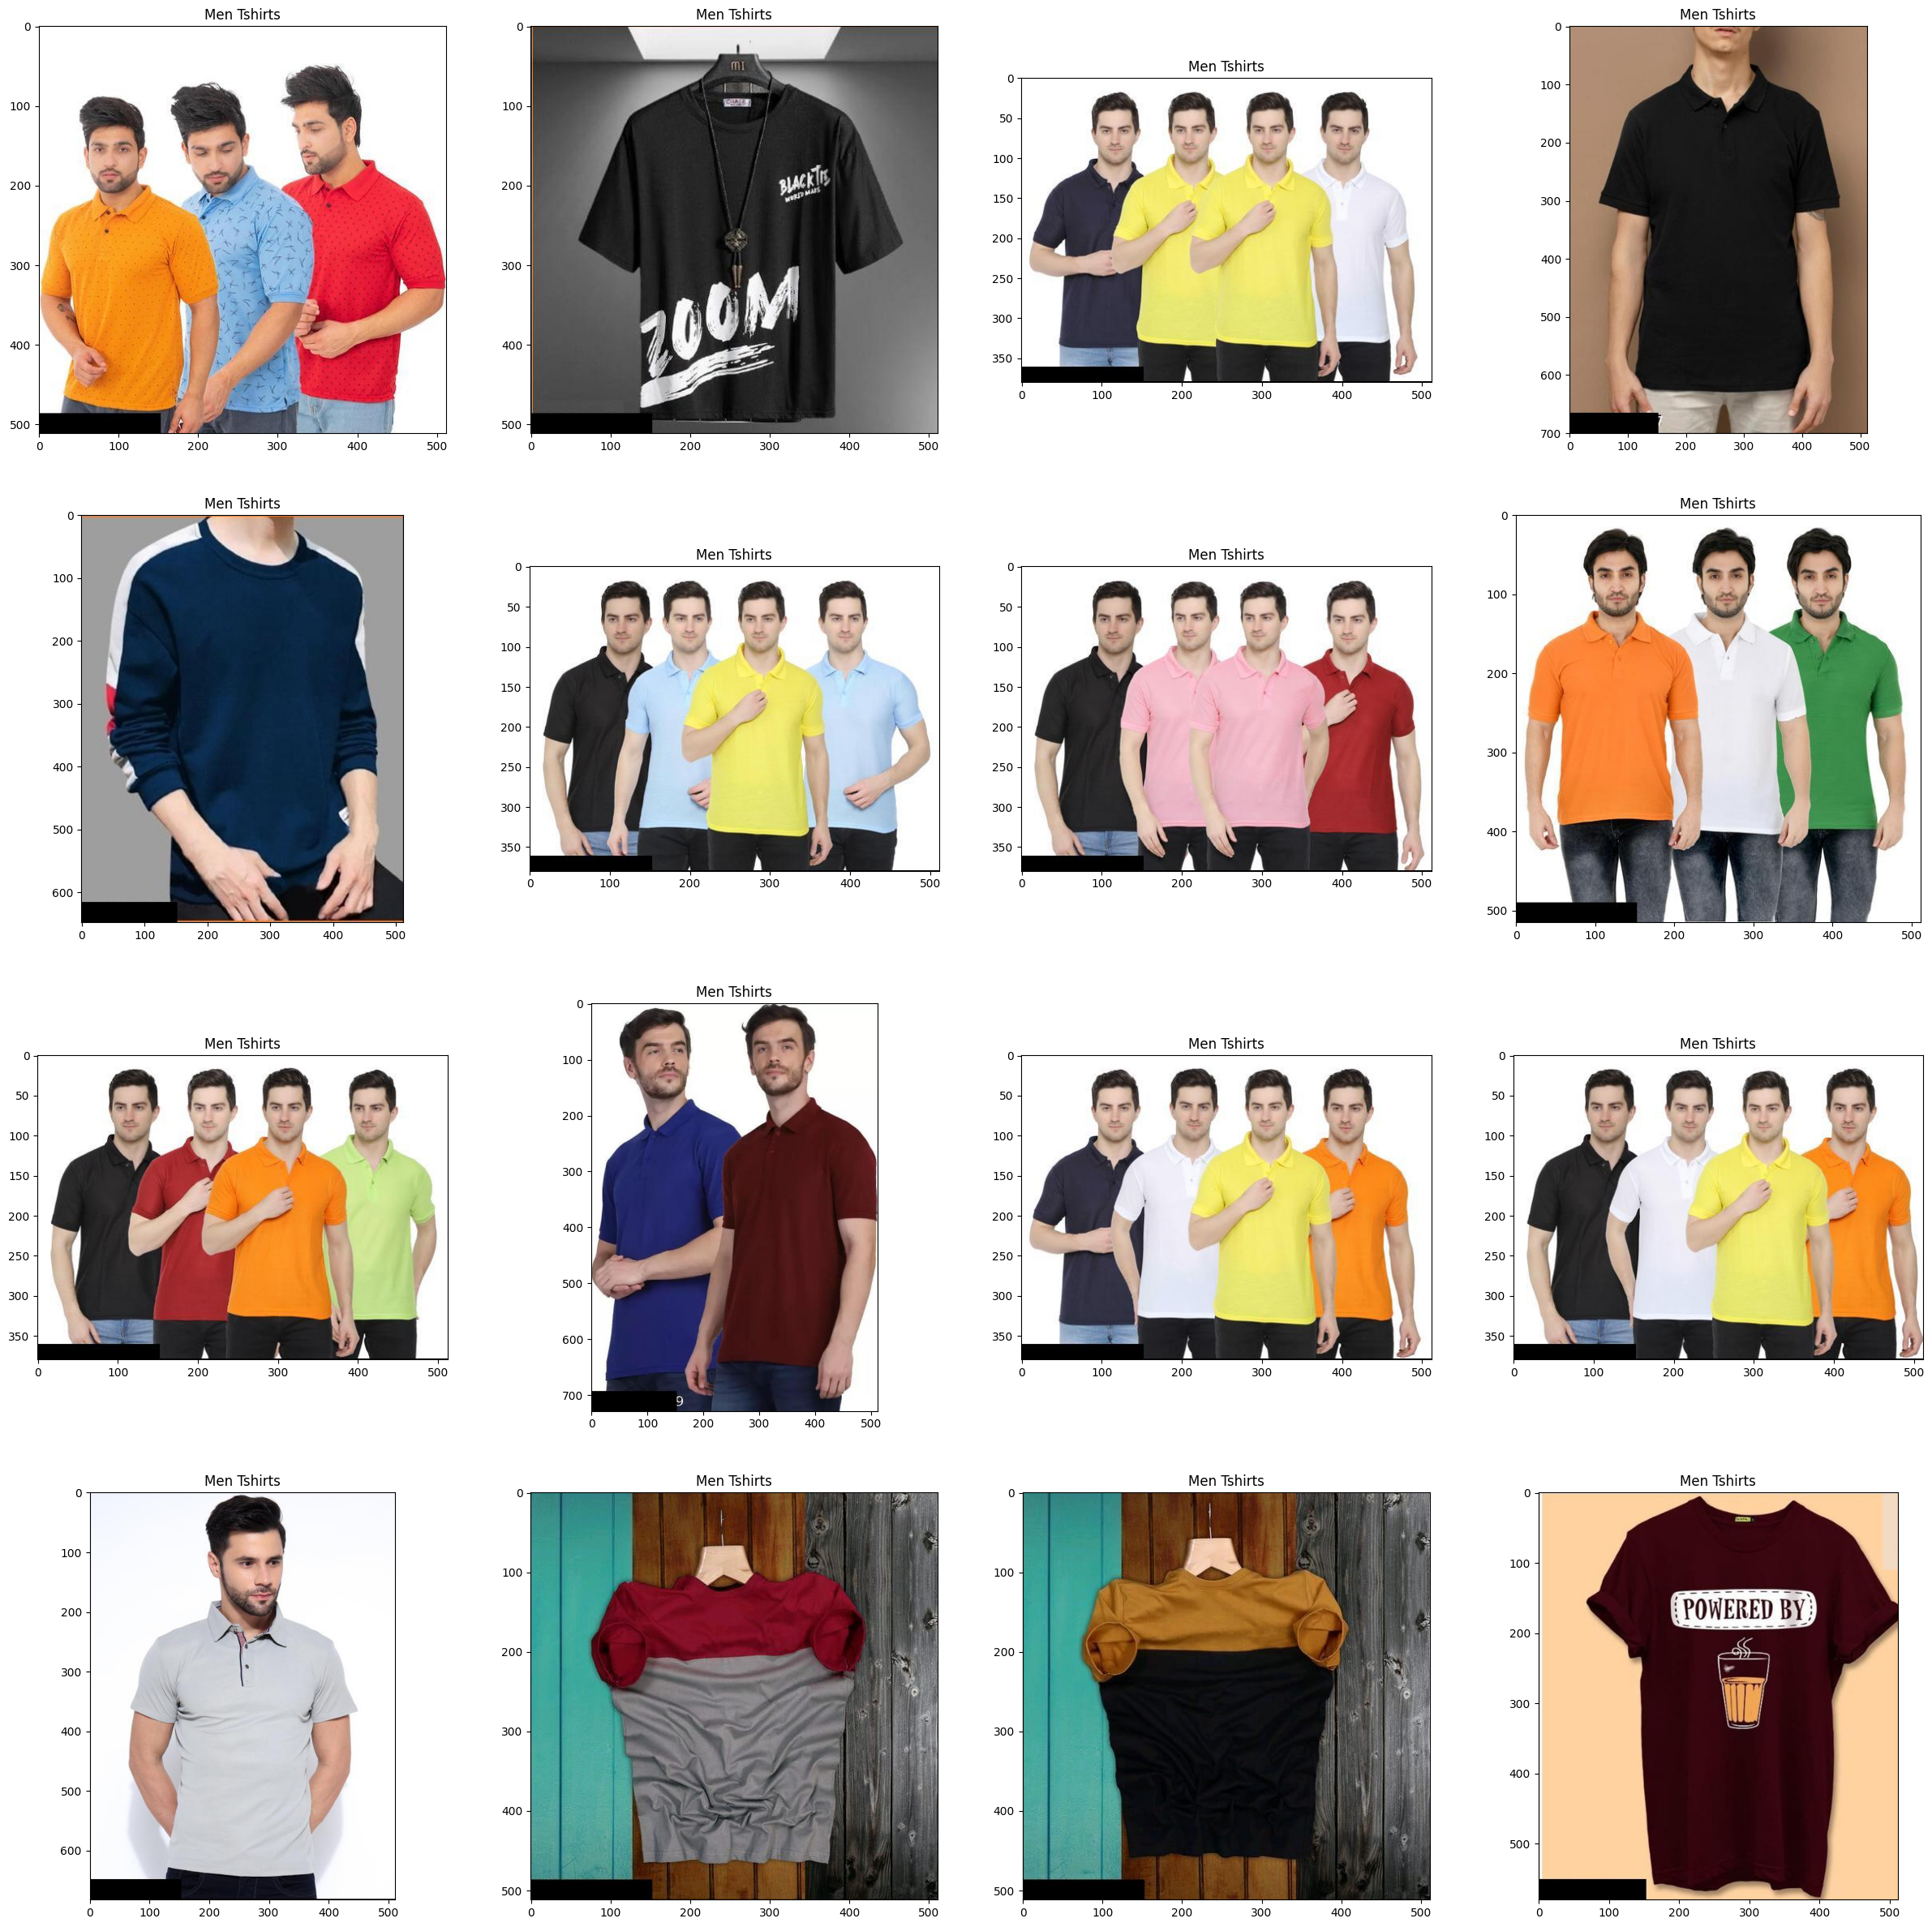

In [137]:
plt.figure(figsize=(30, 30))
for i in range(4):
    for j in range(4):
        idx = random.randint(0, len(df_train))
        img = Image.open(train_image_path / f'{idx:06d}.jpg')
        plt.subplot(4, 4, 4 * i + j + 1)

        plt.imshow(img)
        plt.title(df_train.loc[idx, 'Category'])
    
plt.show()



In [138]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch import optim


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

In [139]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


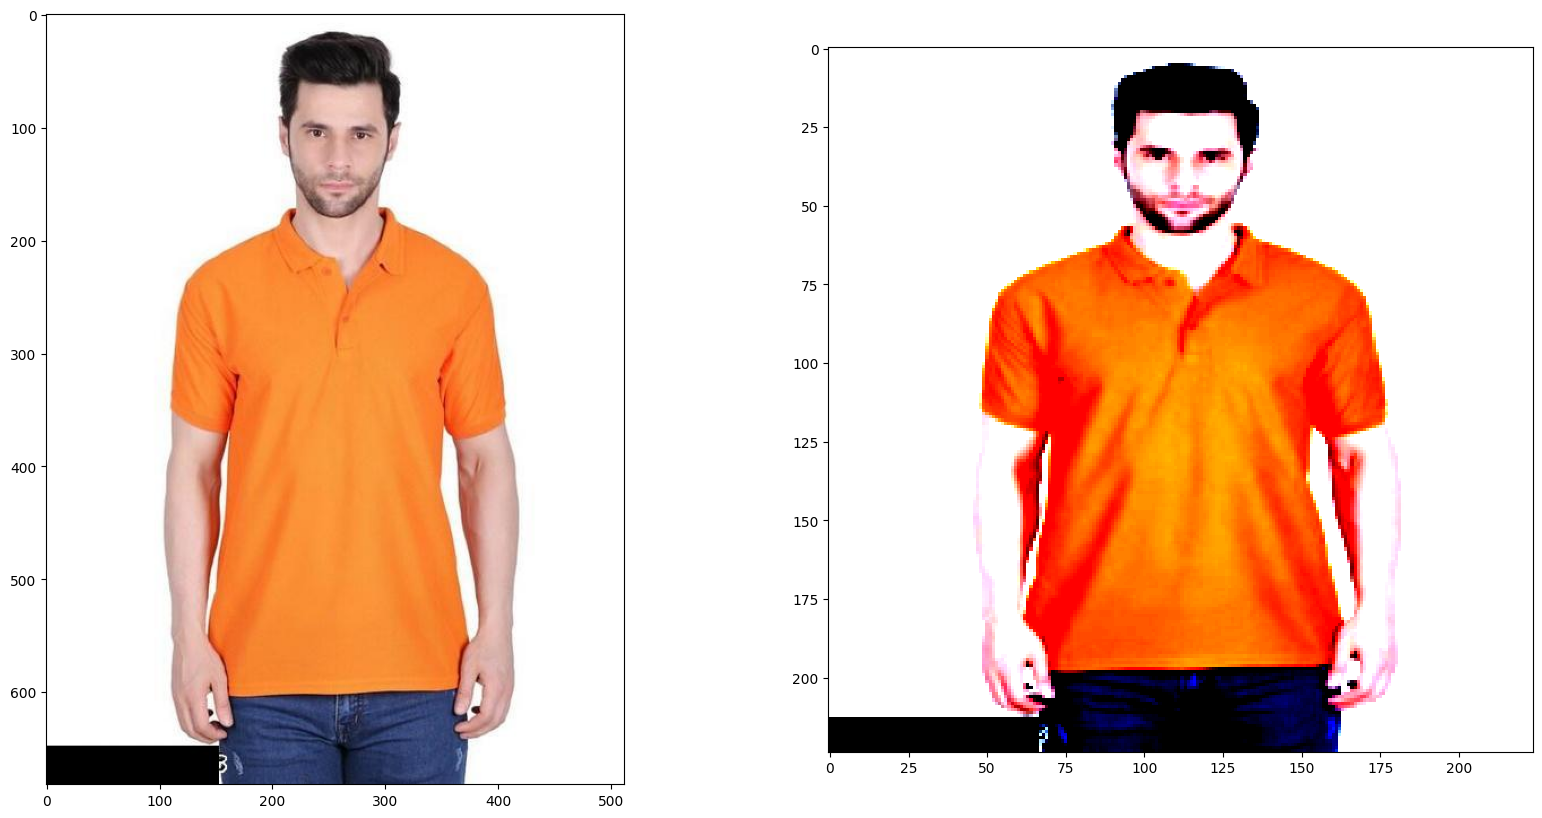

Men Tshirts


In [140]:
num = 560
img = Image.open(train_image_path / f'{num:06d}.jpg')
img_1 = data_transform(img)
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(img_1.permute(1, 2, 0))
plt.show()
print(df_train.loc[num, 'Category'])

In [141]:
df_train['Category'].value_counts()
df_train.fillna('None', inplace=True)

/var/folders/4j/xnkf0xg113jbh1s5hmzbf4lm0000gp/T/ipykernel_43372/1628744365.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'None' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_train.fillna('None', inplace=True)


In [142]:
values = [df_train[col].unique() for col in df_train.columns]
print(values)

[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 1

In [143]:
# list(values[1]).index('Men Tshirts')
values[1]

array(['Men Tshirts'], dtype=object)

In [144]:
def convert_attributes_to_tensor(df):
    # df = df.fillna('None')
    attr_list = [list(values[i]).index(df.iloc[i]) for i in range(1, len(df))]
    return torch.tensor(attr_list)

In [145]:
df_train.loc[0]

id                      0
Category      Men Tshirts
len                     5
attr_1            default
attr_2              round
attr_3            printed
attr_4            default
attr_5      short sleeves
attr_6               None
attr_7               None
attr_8               None
attr_9               None
attr_10              None
Name: 0, dtype: object

In [146]:
convert_attributes_to_tensor(df_train.loc[0])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [147]:
class CustomDataset(Dataset):

    def __init__(self, 
                root_dir: str,
                root_csv: str,
                transform=None):

        self.root_dir = root_dir
        self.root_csv = root_csv
        self.transform = transform

    def __len__(self):
        return len(self.root_csv)

    def __getitem__(self, idx):

        img = Image.open(self.root_dir / f'{idx:06d}.jpg')
        transformed_img = self.transform(img)

        attributes = convert_attributes_to_tensor(self.root_csv.loc[idx])

        return transformed_img, attributes[0]


In [148]:
train_dataset = CustomDataset(train_image_path, df_train, data_transform)
test_dataset = CustomDataset(test_image_path, df_test, data_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0)
Men Tshirts


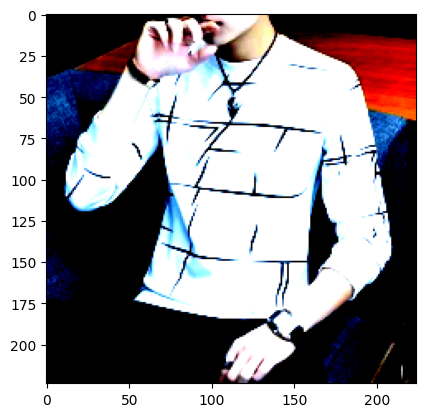

In [149]:
image, label = train_dataset[100]
plt.imshow(image.permute(1, 2, 0))
print(label)
print(values[1][label])

In [150]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [151]:
next(iter(train_loader))

[tensor([[[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
           [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
           [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
           ...,
           [-2.1179, -2.1179, -2.1179,  ...,  2.2489,  2.2489,  2.2489],
           [-2.1179, -2.1179, -2.1179,  ...,  2.2147,  2.2147,  2.2147],
           [-2.1179, -2.1179, -2.1179,  ..., -0.1657, -0.1657, -0.1657]],
 
          [[ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
           [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
           [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
           ...,
           [-2.0357, -2.0357, -2.0357,  ...,  2.4286,  2.4286,  2.4286],
           [-2.0357, -2.0357, -2.0357,  ...,  2.3936,  2.3936,  2.3936],
           [-2.0357, -2.0357, -2.0357,  ..., -0.0399, -0.0399, -0.0399]],
 
          [[ 2.6400,  2.6400,  2.6400,  ...,  2.6400,  2.6400,  2.6400],
           [ 

In [152]:
dataloaders = {'train': train_loader, 'val': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(test_dataset)}

In [153]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [154]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {values[0][preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [155]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(values[0]))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [156]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.4379 Acc: 0.8413
val Loss: 0.0000 Acc: 1.0000

Epoch 1/24
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 0.0000 Acc: 1.0000

Epoch 2/24
----------


KeyboardInterrupt: 